In [13]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.data import Burgers
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepMod, DeepModDynamic

from DeePyMoD_SBL.deepymod_torch.training import train, train_mse

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading tensorboard file

In [3]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard(path):
    # Assumes one file per folder
    event_file = next(filter(lambda filename: filename[:6] =='events', os.listdir(path)))
    summary_iterator = EventAccumulator(str(path + event_file)).Reload()
    
    tags = summary_iterator.Tags()['scalars']
    steps = np.array([event.step for event in summary_iterator.Scalars(tags[0])])
    data = np.array([[event.value for event in summary_iterator.Scalars(tag)] for tag in tags]).T
    df = pd.DataFrame(data=data, index=steps, columns=tags)
    
    return df

# Making data

In [4]:
x = np.linspace(-2, 5, 75)
t = np.linspace(0.5, 5.0, 25)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [5]:
dataset = Burgers(0.1, 1.0)

In [6]:
u = dataset.solution(x_grid, t_grid)

In [7]:
X = np.concatenate((t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)), axis=1)
y = u.reshape(-1, 1)

In [8]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y, dtype=torch.float32, requires_grad=True)

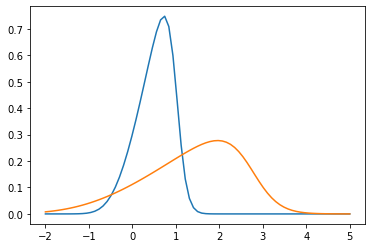

In [9]:
plt.plot(x, u[:, 1])
plt.plot(x, u[:, 24])

In [64]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}}

In [65]:
model = DeepModDynamic(**config)

In [66]:
model.fit.coeff_vector

[tensor([[0.1261],
         [0.1082],
         [0.6862],
         [0.7253],
         [0.5617],
         [0.1164],
         [0.9720],
         [0.5912],
         [0.7796]])]

Let's train without l1 to compare more fair:

In [67]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [68]:
train(model, X_train, y_train, optimizer, 5000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   8.62e-04   7.99e-04   6.26e-05   0.00e+00 

In [69]:
model.fit.coeff_vector

[tensor([[ 0.0046],
         [-0.1393],
         [ 0.0286],
         [ 0.1087],
         [-0.8345],
         [ 0.1030],
         [-0.7297],
         [ 0.6329],
         [-0.4218]], grad_fn=<MmBackward>)]

In [15]:
train_mse(model, X_train, y_train, optimizer, 5000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.23e-05   1.23e-05   0.00e+00   0.00e+00 

In [51]:
model.fit.coeff_vector

[tensor([[0.3363],
         [0.8437],
         [0.5959],
         [0.9920],
         [0.1990],
         [0.4259],
         [0.2937],
         [0.7767],
         [0.3150]])]

In [25]:
thetas = model(X_train)[2]
time_deriv = model(X_train)[1]

In [40]:
[torch.inverse(theta.T @ theta) @ (theta.T @ dt) for theta, dt in zip(thetas, time_deriv)]

[tensor([[ 1.2562e-04],
         [-3.7058e-02],
         [ 8.8518e-02],
         [ 9.9438e-02],
         [-1.4182e+00],
         [-4.0345e-02],
         [-4.4426e-01],
         [ 4.7612e-01],
         [-2.8996e-02]], grad_fn=<MmBackward>)]

In [33]:
[idx for idx, theta in enumerate(thetas)]

[0]

In [37]:
time_deriv[:, 0:1]

TypeError: list indices must be integers or slices, not tuple

In [38]:
time_deriv

[tensor([[ 0.0097],
         [ 0.0026],
         [-0.0029],
         ...,
         [-0.0012],
         [-0.0023],
         [-0.0036]], grad_fn=<SliceBackward>)]